<a href="https://colab.research.google.com/github/CoderAPS/anomaly_detection/blob/main/anomaly(outlier)_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using Autoencoders in Tensorflow Keras for Anomaly Detection ###

Ref: https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/<br>

Ref: https://alpersinbalc.medium.com/using-autoencoders-in-tensorflow-keras-for-anomaly-detection-2ce9c34435ce

In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
    # build encoder
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		print(f'volumeSize: {volumeSize}')
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")





    # start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import argparse

%matplotlib inline

In [ ]:
def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):

	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	# return the set of images
	return images

In [ ]:
def visualize_predictions(decoded, gt, samples=10):

	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [ ]:
# help with argparse in colab
# https://colab.research.google.com/github/anthony-agbay/introduction-to-python/blob/main/modules/introduction-argparse-pt1/introduction-argparse-pt1.ipynb

# Now that we’ve defined our imports and necessary functions,
# we’ll go ahead and parse our command line arguments:

%%writefile parsing.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

import argparse

# construct the argument parse and parse the arguments: 1rst ste
ap = argparse.ArgumentParser()

# add arguments: 2nd step
ap.add_argument("-d", "--dataset", type=str, required=True,
	help="path to output dataset file")

ap.add_argument("-m", "--model", type=str, required=True,
	help="path to output trained autoencoder")

ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
	help="path to output reconstruction visualization file")

ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output plot file")

# Indicate end of argument definitions and parse args: 3rd step
args = ap.parse_args()



Overwriting parsing.py


In [ ]:
# Example of a correct call
!python parsing.py "-d/--dataset"

NameError: name 'args' is not defined

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
	anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,
	random_state=42)

[INFO] loading MNIST dataset...
11490434/11490434 [==============================] - 0s 0us/step
[INFO] creating unsupervised dataset...


In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
print(f'autoencoder: {autoencoder.summary()}')
print('-'*100)
print(f'encoder: {encoder.summary()}')
print('-'*100)
print(f'decoder: {autoencoder.summary()}')
print('-'*100)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
#cv2.imwrite(args["vis"], vis)

[INFO] building autoencoder...
volumeSize: (None, 7, 7, 64)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178769 (698.32 KB)
Trainable params: 178385 (696.82 KB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________
autoencoder: None
----------------------------------------------------------------------------------------------------
Model: "encoder"
_________________________________________________________________
 Layer (type)    

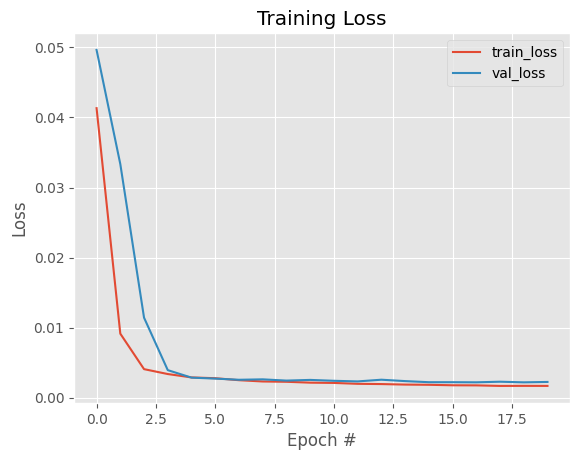

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()
#plt.savefig(args["plot"])

# serialize the image data to disk
#print("[INFO] saving image data...")
#f = open(args["dataset"], "wb")
#f.write(pickle.dumps(images))
#f.close()

# serialize the autoencoder model to disk
#print("[INFO] saving autoencoder...")
#autoencoder.save(args["model"], save_format="h5")

280

In [ ]:
#====================================================================================================================
# Ref: https://alpersinbalc.medium.com/using-autoencoders-in-tensorflow-keras-for-anomaly-detection-2ce9c34435ce

In [ ]:
# For synthetic dataset
from sklearn.datasets import make_classification

# for data preprocessing
import numpy as np
import pandas as pd
from collections import Counter

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# for model performance
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# building imbalanced dataset
X, y = make_classification(n_samples=100000,
                           n_features=32,
                           n_informative=32,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=3,
                           weights=[0.495,0.495, 0.01],
                           class_sep=1,
                           random_state=0)

In [ ]:
# number of classes in target
np.unique(y)
y_series = pd.Series(y)

In [ ]:
y_series.value_counts(normalize=True)

0    0.49339
1    0.49299
2    0.01362
dtype: float64

In [ ]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Control the number of records
print('The number of records in the training dataset is', X_train.shape[0])



The number of records in the training dataset is 80000


In [ ]:
# Keep only the normal data for the training dataset
X_train_normal = X_train[np.where((y_train == 0) | (y_train == 1))]
y_train_normal = y_train[np.where((y_train == 0) | (y_train == 1))]

# Input layer
input = tf.keras.layers.Input(shape=(32,))

# Encoder layers
encoder = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu')])(input)

# Decoder layers
decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(32, activation="softmax")])(encoder)

# Create the autoencoder
autoencoder = tf.keras.Model(inputs=input, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 sequential (Sequential)     (None, 4)                 700       
                                                                 
 sequential_1 (Sequential)   (None, 32)                728       
                                                                 
Total params: 1428 (5.58 KB)
Trainable params: 1428 (5.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
ds = pd.Series(y_train_normal)
ds.value_counts()

1    39526
0    39388
dtype: int64

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
# Fit the autoencoder
history = autoencoder.fit(X_train_normal, y_train_normal,
          epochs=20,
          batch_size=64,
          validation_data=(X_test, y_test),
          shuffle=True)


Epoch 1/20
1234/1234 [==============================] - 3s 2ms/step - loss: 0.5008 - accuracy: 0.1415 - val_loss: 0.5161 - val_accuracy: 0.1384
Epoch 2/20
1234/1234 [==============================] - 3s 2ms/step - loss: 0.5008 - accuracy: 0.1377 - val_loss: 0.5161 - val_accuracy: 0.1384
Epoch 3/20
1234/1234 [==============================] - 2s 2ms/step - loss: 0.5008 - accuracy: 0.1377 - val_loss: 0.5161 - val_accuracy: 0.1384
Epoch 4/20
1234/1234 [==============================] - 2s 2ms/step - loss: 0.5008 - accuracy: 0.1377 - val_loss: 0.5161 - val_accuracy: 0.1384
Epoch 5/20
1234/1234 [==============================] - 2s 2ms/step - loss: 0.5008 - accuracy: 0.1377 - val_loss: 0.5161 - val_accuracy: 0.1383
Epoch 6/20
1234/1234 [==============================] - 2s 2ms/step - loss: 0.5008 - accuracy: 0.1377 - val_loss: 0.5161 - val_accuracy: 0.1383
Epoch 7/20
1234/1234 [==============================] - 2s 2ms/step - loss: 0.5008 - accuracy: 0.1377 - val_loss: 0.5161 - val_accuracy:

In [ ]:
def evaluate_model(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12,4))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='upper left')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')


  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Loss')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')



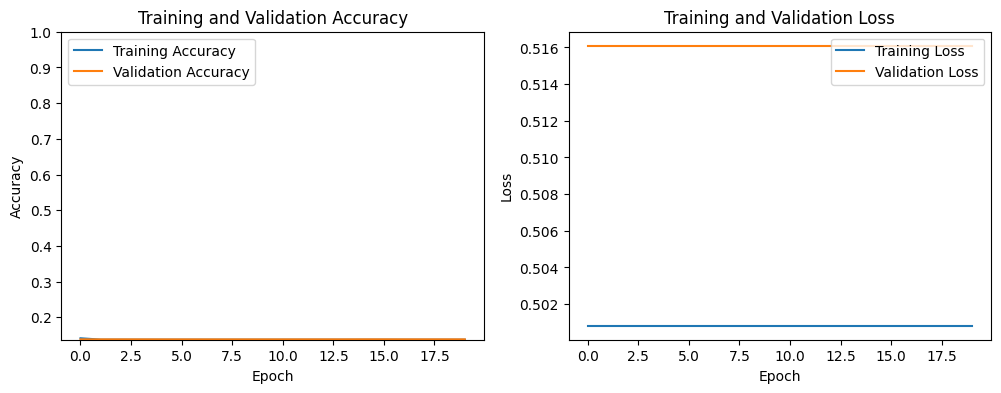

In [ ]:
evaluate_model(history)

625/625 [==============================] - 1s 1ms/step
The prediction loss threshold for 1% of outliers is 3.79


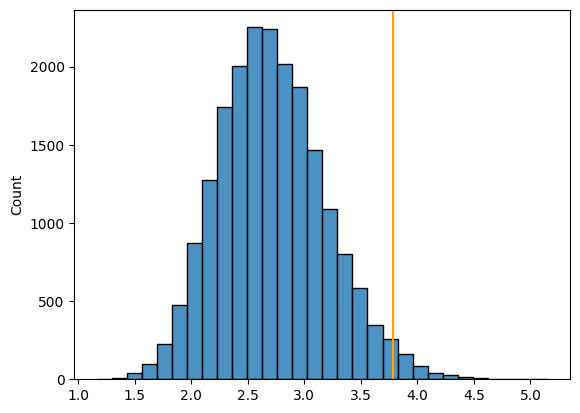

In [ ]:
# for predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)

# for get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, X_test)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 1% of outliers is {loss_threshold:.2f}')
# for visualize the threshold

sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')

In [ ]:
X_test

array([-1.62529549, -1.9691789 ,  3.83751132, -1.032465  , -3.04709354,
       -7.71239844,  1.66093319,  2.61826027,  1.07392468, -0.71107072,
        0.19217089, -3.72515755,  0.53067423, -6.3091231 ,  0.47756369,
       -1.32866776,  6.97656283,  9.08994224, -2.33444957,  4.95951884,
        3.82789327,  2.73993009,  6.02269218,  1.30897628,  4.30851177,
        2.06122997, -2.84380965, -0.95697877, -5.00594611, -1.0719376 ,
        5.41924751,  3.31983281])

In [ ]:
# for control the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]

# for control the prediction performance
print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

           0       0.50      0.99      0.66      9951
           1       0.64      0.03      0.05      9773
           2       0.00      0.00      0.00       276

    accuracy                           0.50     20000
   macro avg       0.38      0.34      0.24     20000
weighted avg       0.56      0.50      0.36     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
